In [1]:
import pandas as pd 
import nltk  
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator   
from colour import Color
from reportlab.lib.pagesizes import letter, landscape  
from reportlab.pdfgen import canvas
from IPython.display import Markdown
import os

In [2]:
DARK_BLUE = '#3557A9'
DARK_GREEN = '#50974F'
DARK_RED = '#D43F2C'
DARK_YELLOW = '#F8D65A'

BLUE = '#627EC3'
GREEN = '#7ABA79'
RED = '#E36656'
YELLOW = '#FFE480'

LIGHT_BLUE = '#8CA5E2'
LIGHT_GREEN = '#A3D9A3'
LIGHT_RED = '#F6887A'
LIGHT_YELLOW = '#FFEA9D'

## Load Data

In [3]:
import pandas as pd

# Caminhos para os arquivos CSV
sheets_path = 'C:/Users/leibr/Documents/Lappis/data/2023-53345.csv' #sheets 
planilha_path = 'C:/Users/leibr/Documents/Lappis/data/Propostas-Brasil-Participativo-TagsCategorias.csv' #planilha

# Carregar os arquivos CSV
df_sheets = pd.read_csv(sheets_path, sep=';')
df_planilha = pd.read_csv(planilha_path, sep=';')


## Pre-Process Data

In [4]:
# Convertendo a coluna 'ID' em df_planilha para int64
df_planilha['ID'] = df_planilha['ID'].astype(int)

# Mesclando data sheets e planilha
df = pd.merge(df_sheets, df_planilha, left_on='id', right_on='ID', how='left')

# Remover (state = rejected) ou (state = withdrawn)
df = df[df['state'] != 'rejected']
df = df[df['state'] != 'withdrawn']

# Remover html tags from body
df['body/pt-BR'] = df['body/pt-BR'].str.replace(r'<[^>]*>', '', regex=True)

In [5]:
# Convertendo a coluna 'ID' em df_planilha para int64
df_planilha['ID'] = df_planilha['ID'].astype(int)

# Mesclando data sheets e planilha
df = pd.merge(df_sheets, df_planilha, left_on='id', right_on='ID', how='left')

# Remover (state = rejected) ou (state = withdrawn)
df = df[df['state'] != 'rejected']
df = df[df['state'] != 'withdrawn']

# Remover html tags from body
df['body/pt-BR'] = df['body/pt-BR'].str.replace(r'<[^>]*>', '', regex=True)


### Criar arquivo MD

In [6]:
# Criar arquivo de relatório Markdown
report_path = '../notebooks/relatorio.md'
with open(report_path, 'w', encoding='utf-8') as report_file:
    # Adicionar título e subtítulo
    report_file.write("# Relatório de Análise de Dados\n")
    report_file.write("## Resultados da Análise\n")

### ANÁLISE GERAL: Propostas Categorizadas Manualmente

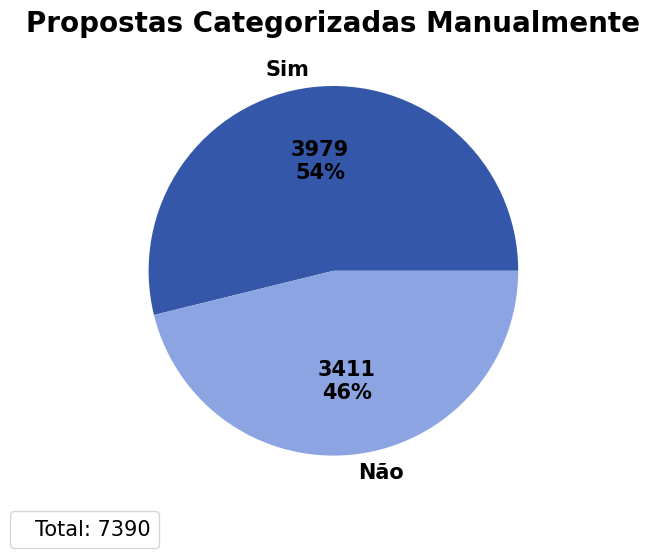

In [7]:
# Gráfico 1: Pie Chart - Propostas Categorizadas Manualmente
plt.figure(figsize=(6, 6))
df['ID'].notna().value_counts().plot.pie(
    autopct=lambda p: f"{p * df.shape[0] / 100 :.0f}\n{p:.0f}%",
    fontsize=15,
    ylabel='',
    labels=['Sim', 'Não'],
    textprops={'color': 'black', 'fontweight': 'semibold'},
    colors=[DARK_BLUE, LIGHT_BLUE],
)

plt.title('Propostas Categorizadas Manualmente', fontsize=20, fontweight='bold')
plt.legend([f'Total: {df.shape[0]:.0f}'], loc=(-0.2, -0.1), fontsize=15, handlelength=0)

# Salvar gráfico como imagem
plt.savefig('../data/output/prop_categorizadas_manual.png', dpi=100, bbox_inches='tight')

# Adicionar título e gráfico ao arquivo de relatório
with open(report_path, 'a', encoding='utf-8') as report_file:
    # Observe que usamos um contador para o número do gráfico
    num_grafico = 1
    report_file.write("### Propostas Categorizadas Manualmente\n")
    # Adicionar a imagem do gráfico centralizado
    report_file.write('<p align="center">\n')
    report_file.write('  <img src="../data/output/prop_categorizadas_manual.png" alt="Gráfico 1: Propostas Categorizadas Manualmente">\n')
    report_file.write('</p>\n\n')
    
    # Adicionar legenda em itálico e centralizada
    report_file.write('<p align="center">\n')
    report_file.write('  <i>Gráfico 1: Propostas Categorizadas Manualmente</i>\n')
    report_file.write('</p>\n\n')
    
    # Adicionar descrição do gráfico
    report_file.write("No Gráfico 1, é possível visualizar a distribuição das propostas categorizadas manualmente.\n\n")


### ANÁLISE GERAL: Propostas por Ministério

In [8]:
# Gráfico 2: Quantidade de Propostas por Ministério
plt.figure(figsize=(10, 10))
TOP = 2
df.groupby('category/name/pt-BR')['category/name/pt-BR'].count() \
    .sort_values(ascending=True).tail(40) \
    .plot.barh(title='Votos por Ministério',
                figsize=(10, 10),
                ylabel='',
                xlim=(0, 1333 + 100),
                color=[color.rgb for color in list(Color('white').range_to(Color(DARK_BLUE),40))],
                # add bar_label
               ).bar_label(container=plt.gca().containers[0], fmt=' %.0f')
plt.title('Quantidade de PROPOSTAS por Ministério', fontsize=20, fontweight='bold')

# Salvar gráfico como imagem
plt.savefig('../data/output/quant_prop_por_ministerio.png', dpi=100, bbox_inches='tight')
plt.close()

# Adicionar título e gráfico ao arquivo de relatório
with open(report_path, 'a', encoding='utf-8') as report_file:
    # Observe que usamos um contador para o número do gráfico
    num_grafico += 1
    report_file.write(f"### Quantidade de Propostas por Ministério\n")
    
    # Adicionar a imagem do gráfico centralizado
    report_file.write('<p align="center">\n')
    report_file.write(f'  <img src="../data/output/quant_prop_por_ministerio.png" alt="Gráfico {num_grafico}: Quantidade de Propostas por Ministério">\n')
    report_file.write('</p>\n\n')
    
    # Adicionar legenda em itálico e centralizada
    report_file.write('<p align="center">\n')
    report_file.write(f'  <i>Gráfico {num_grafico}: Quantidade de Propostas por Ministério</i>\n')
    report_file.write('</p>\n\n')
    
    # Adicionar descrição do gráfico
    report_file.write(f"No Gráfico {num_grafico}, é possível visualizar a quantidade de propostas por ministério, apresentando os ministérios com mais propostas.\n\n")


### ANÁLISE GERAL: Votos por Ministério

In [9]:
# Gráfico 3: Quantidade de Votos por Ministério
plt.figure(figsize=(10, 10))
TOP = 3
df.groupby('category/name/pt-BR')['supports'].sum() \
    .sort_values(ascending=True).tail(40) \
    .plot.barh(title='Votos por Ministério',
                figsize=(10, 10),
                ylabel='',
                xlim=(0, 360000 + 50000),
                color=[color.rgb for color in list(Color('white').range_to(Color(DARK_GREEN),40))],
                # add bar_label
               ).bar_label(container=plt.gca().containers[0], fmt=' %.0f')
plt.title('Quantidade de VOTOS por Ministério', fontsize=20, fontweight='bold')

# Salvar gráfico como imagem
plt.savefig('../data/output/quant_votos_por_ministerio.png', dpi=100, bbox_inches='tight')
plt.close()

# Adicionar título e gráfico ao arquivo de relatório
with open(report_path, 'a', encoding='utf-8') as report_file:
    # Observe que usamos um contador para o número do gráfico
    num_grafico += 1
    report_file.write(f"### Quantidade de Votos por Ministério\n")
    
    # Adicionar a imagem do gráfico centralizado
    report_file.write('<p align="center">\n')
    report_file.write(f'  <img src="../data/output/quant_votos_por_ministerio.png" alt="Gráfico {num_grafico}: Quantidade de Votos por Ministério">\n')
    report_file.write('</p>\n\n')
    
    # Adicionar legenda em itálico e centralizada
    report_file.write('<p align="center">\n')
    report_file.write(f'  <i>Gráfico {num_grafico}: Quantidade de Votos por Ministério</i>\n')
    report_file.write('</p>\n\n')
    
    # Adicionar descrição do gráfico
    report_file.write(f"No Gráfico {num_grafico}, é possível visualizar a quantidade de votos por ministério, apresentando os ministérios com mais votos em propostas.\n\n")


## PRE-PROCESS CATEGORIES

In [10]:
category_df = df[['id', 'category/name/pt-BR', 'Categoria 1', 'Categoria 2', 'supports']].dropna()
category_df

# Category 1 and 2 into the same column (Categoria)
category_df['Categoria'] = category_df['Categoria 1'] + '/' + category_df['Categoria 2']
category_df = category_df[['id', 'category/name/pt-BR', 'Categoria', 'supports']]

# Explode Categoria split by '/' and trim spaces
category_df = category_df.assign(Categoria=category_df['Categoria'].str.split('/')).explode('Categoria')
category_df['Categoria'] = category_df['Categoria'].str.strip()
category_df

,id,category/name/pt-BR,Categoria,supports
2,3503,"Ciência, Tecnologia e Inovação",Financiamento,4
2,3503,"Ciência, Tecnologia e Inovação",Acessibilidade,4
4,4,Saúde,Saúde,0
4,4,Saúde,Atenção Primária,0
5,6,"Desenvolvimento e Assistência Social, Família ...",Bolsa Família,0
...,...,...,...,...
7575,1682,Trabalho e Emprego,Sistema S,152
7579,71,Minas e Energia,Estatização,3390
7579,71,Minas e Energia,Eletricidade,3390
7579,71,Minas e Energia,Empresas Públicas,3390


In [11]:
# Gráfico 4: Quantidade de Votos por Categoria
plt.figure(figsize=(10, 10))
TOP = 5
SHOW = 20
column = 'Categoria'

category_df.groupby(column)['supports'].sum().sort_values(ascending=True).tail(SHOW) \
    .plot.barh(figsize=(10, 10),
                ylabel='',
                # fit bar to view
                xlim=(0, category_df.groupby(column)['supports'].sum().sort_values(ascending=True).tail(1)[0] * 1.1),
                color=([LIGHT_GREEN] * (SHOW - TOP)) + ([DARK_GREEN] * TOP),
               ).bar_label(container=plt.gca().containers[0], fmt=' %.0f')
    
plt.title("Quantidade de VOTOS por " + column, fontsize=20, fontweight='bold', loc='center', pad=15)
for i in range(TOP):
    plt.gca().get_yticklabels()[-i-1].set_fontweight('bold')

# Salvar gráfico como imagem
plt.savefig('../data/output/quant_votos_por_categoria.png', dpi=100, bbox_inches='tight')
plt.close()

# Adicionar título e gráfico ao arquivo de relatório
with open(report_path, 'a', encoding='utf-8') as report_file:
    # Observe que usamos um contador para o número do gráfico
    num_grafico += 1
    report_file.write(f"### Quantidade de Votos por {column}\n")
    
    # Adicionar a imagem do gráfico centralizado
    report_file.write('<p align="center">\n')
    report_file.write(f'  <img src="../data/output/quant_votos_por_categoria.png" alt="Gráfico {num_grafico}: Quantidade de Votos por Categoria">\n')
    report_file.write('</p>\n\n')
    
    # Adicionar legenda em itálico e centralizada
    report_file.write('<p align="center">\n')
    report_file.write(f'  <i>Gráfico {num_grafico}: Quantidade de Votos por Categoria</i>\n')
    report_file.write('</p>\n\n')
    
    # Adicionar descrição do gráfico
    report_file.write(f"No Gráfico {num_grafico}, é possível visualizar a quantidade de votos por categoria, apresentando as categorias com mais votos.\n\n")


In [12]:
# Gráfico 5: Quantidade de Propostas por Categoria
plt.figure(figsize=(7, 10))
TOP = 5
SHOW = 20
column = 'Categoria'

category_df[column].value_counts().sort_values(ascending=True).tail(SHOW) \
    .plot.barh(figsize=(7, 10),
                ylabel='',
                # fit bar to view
                xlim=(0, category_df[column].value_counts().sort_values(ascending=True).tail(1)[0] * 1.1),
                color=([LIGHT_BLUE] * (SHOW - TOP)) + ([DARK_BLUE] * TOP),
               ).bar_label(container=plt.gca().containers[0], fmt=' %.0f')
    
plt.title("Quantidade de PROPOSTAS por " + column, fontsize=20, fontweight='bold', loc='left', pad=15)
for i in range(TOP):
    plt.gca().get_yticklabels()[-i-1].set_fontweight('bold')

# Salvar gráfico como imagem
plt.savefig('../data/output/quant_prop_por_categoria.png', dpi=100, bbox_inches='tight')
plt.close()

# Adicionar título e gráfico ao arquivo de relatório
with open(report_path, 'a', encoding='utf-8') as report_file:
    # Observe que usamos um contador para o número do gráfico
    num_grafico += 1
    report_file.write(f"### Quantidade de Propostas por {column}\n")
    
    # Adicionar a imagem do gráfico centralizado
    report_file.write('<p align="center">\n')
    report_file.write(f'  <img src="../data/output/quant_prop_por_categoria.png" alt="Gráfico {num_grafico}: Quantidade de Propostas por Categoria">\n')
    report_file.write('</p>\n\n')
    
    # Adicionar legenda em itálico e centralizada
    report_file.write('<p align="center">\n')
    report_file.write(f'  <i>Gráfico {num_grafico}: Quantidade de Propostas por Categoria</i>\n')
    report_file.write('</p>\n\n')
    
    # Adicionar descrição do gráfico
    report_file.write(f"No Gráfico {num_grafico}, é possível visualizar a quantidade de propostas por categoria, apresentando as categorias com mais propostas.\n\n")


# Análise por Ministério

In [13]:
# Gerar gráficos de pizza para cada ministério
for ministério in category_df['category/name/pt-BR'].unique():
    plt.figure(figsize=(6, 6))
    df_ministerio = df[df['category/name/pt-BR'] == ministério]
    df_ministerio['ID'].notna().value_counts().plot.pie(
        autopct=lambda p: f"{p * df_ministerio.shape[0] / 100 :.0f}\n{p:.0f}%",
        fontsize=15,
        ylabel='',
        labels=['Sim', 'Não'],
        textprops={'color': 'black', 'fontweight': 'semibold'},
        colors=[DARK_BLUE, LIGHT_BLUE],
    )
    plt.title(f"{ministério} - Propostas Categorizadas Manualmente", fontsize=20, fontweight='bold')
    plt.legend([f"Total: {df_ministerio.shape[0]:.0f}"], loc=(-0.2, -0.1), fontsize=15, handlelength=0)
    
    # Salvar gráfico como imagem
    ministério_filename = ministério.lower().replace(' ', '_')
    plt.savefig(f'../data/output/{ministério_filename}_categorizacao_manual.png', dpi=100, bbox_inches='tight')
    plt.close()

    # Adicionar título, gráfico e descrição ao arquivo de relatório
    with open(report_path, 'a', encoding='utf-8') as report_file:
        # Observe que usamos um contador para o número do gráfico
        num_grafico += 1
        report_file.write(f"### {ministério} - Propostas Categorizadas Manualmente\n")
        
        # Adicionar a imagem do gráfico
        report_file.write('<p align="center">\n')
        report_file.write(f'  <img src="../data/output/{ministério_filename}_categorizacao_manual.png" alt="{ministério} - Propostas Categorizadas Manualmente">\n')
        report_file.write('</p>\n\n')
        
        # Adicionar legenda em itálico centralizada
        report_file.write('<p align="center">\n')
        report_file.write(f'  <i>Gráfico {num_grafico}: {ministério} - Propostas Categorizadas Manualmente</i>\n')
        report_file.write('</p>\n\n')
        
        # Adicionar descrição do gráfico
        report_file.write(f"Este gráfico de pizza mostra a proporção de propostas categorizadas manualmente para o ministério {ministério}, indicando quantas foram categorizadas e quantas não foram.\n\n")


In [80]:
TOP = 5
SHOW = 20
column = 'Categoria'

for ministério in category_df['category/name/pt-BR'].unique():
    plt.figure(figsize=(15, 10))
    ministério_df = category_df[category_df['category/name/pt-BR'] == ministério]
    ministério_df.groupby(column)['supports'].sum().sort_values(ascending=True).tail(SHOW) \
        .plot.barh(figsize=(15, 10),
                    ylabel='',
                    # fit bar to view
                    xlim=(0, ministério_df.groupby(column)['supports'].sum().sort_values(ascending=True).tail(1)[0] * 1.1),
                    color=([LIGHT_GREEN] * (ministério_df[column].value_counts().sort_values(ascending=True).tail(SHOW).shape[0] - TOP)) + ([DARK_GREEN] * TOP),
                   ).bar_label(container=plt.gca().containers[0], fmt=' %.0f')
        
    plt.title(f"{ministério} - Quantidade de VOTOS por " + column, fontsize=16, fontweight='bold', loc='left', pad=15)
    for i in range(TOP):
        plt.gca().get_yticklabels()[-i-1].set_fontweight('bold')
    
    # Salvar gráfico como imagem
    ministério_filename = ministério.lower().replace(' ', '_')
    plt.savefig(f'../data/output/{ministério_filename}_qnt_votos_por_categoria.png', dpi=100, bbox_inches='tight')
    plt.close()

    # Adicionar título, gráfico e descrição ao arquivo de relatório
    with open(report_path, 'a', encoding='utf-8') as report_file:
        # Observe que usamos um contador para o número do gráfico
        num_grafico += 1
        report_file.write(f"### {ministério} - Quantidade de VOTOS por {column}\n")
        
        # Adicionar a imagem do gráfico
        report_file.write('<p align="center">\n')
        report_file.write(f'  <img src="../data/output/{ministério_filename}_qnt_votos_por_categoria.png" alt="{ministério} - Quantidade de VOTOS por {column}">\n')
        report_file.write('</p>\n\n')
        
        # Adicionar legenda em itálico centralizada
        report_file.write('<p align="center">\n')
        report_file.write(f'  <i>Gráfico {num_grafico}: {ministério} - Quantidade de VOTOS por {column}</i>\n')
        report_file.write('</p>\n\n')
        
        # Adicionar descrição do gráfico
        report_file.write(f"Este gráfico de barras mostra a quantidade de votos por categoria para o ministério {ministério}, exibindo as categorias com mais votos.\n\n")


In [14]:
TOP = 5
SHOW = 20
column = 'Categoria'

for ministério in category_df['category/name/pt-BR'].unique():
    plt.figure(figsize=(15, 10))
    ministério_df = category_df[category_df['category/name/pt-BR'] == ministério]
    ministério_df[column].value_counts().sort_values(ascending=True).tail(SHOW) \
        .plot.barh(figsize=(15, 10),
                    ylabel='',
                    # fit bar to view
                    xlim=(0, ministério_df[column].value_counts().sort_values(ascending=True).tail(1)[0] * 1.1),
                    color=([LIGHT_BLUE] * (ministério_df[column].value_counts().sort_values(ascending=True).tail(SHOW).shape[0] - TOP)) + ([DARK_BLUE] * TOP),
                   ).bar_label(container=plt.gca().containers[0], fmt=' %.0f')
        
    plt.title(f"{ministério} - Quantidade de PROPOSTAS por " + column, fontsize=16, fontweight='bold', loc='left', pad=15)
    for i in range(TOP):
        plt.gca().get_yticklabels()[-i-1].set_fontweight('bold')
    
    # Salvar gráfico como imagem
    ministério_filename = ministério.lower().replace(' ', '_')
    plt.savefig(f'../data/output/{ministério_filename}_qnt_propostas_por_categoria.png', dpi=100, bbox_inches='tight')
    plt.close()

    # Adicionar título, gráfico e descrição ao arquivo de relatório
    with open(report_path, 'a', encoding='utf-8') as report_file:
        # Observe que usamos um contador para o número do gráfico
        num_grafico += 1
        report_file.write(f"### {ministério} - Quantidade de PROPOSTAS por {column}\n")
        
        # Adicionar a imagem do gráfico
        report_file.write('<p align="center">\n')
        report_file.write(f'  <img src="../data/output/{ministério_filename}_qnt_propostas_por_categoria.png" alt="{ministério} - Quantidade de PROPOSTAS por {column}">\n')
        report_file.write('</p>\n\n')
        
        # Adicionar legenda em itálico centralizada
        report_file.write('<p align="center">\n')
        report_file.write(f'  <i>Gráfico {num_grafico}: {ministério} - Quantidade de PROPOSTAS por {column}</i>\n')
        report_file.write('</p>\n\n')
        
        # Adicionar descrição do gráfico
        report_file.write(f"Este gráfico de barras mostra a quantidade de propostas por categoria para o ministério {ministério}, exibindo as categorias com mais propostas.\n\n")
